# Imports

In [38]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Dataset

In [39]:
tf.random.set_seed(42)
np.random.seed(42)
img_size = 224
batch_size = 32
dataset_path = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

In [40]:
class_name_to_label = {
    'banana_overripe': 0,
    'banana_ripe': 1,
    'banana_rotten': 2,
    'banana_unripe': 3,
    'tomato_fully_ripened': 4,
    'tomato_green': 5,
    'tomato_half_ripened': 6
}


img_size = 224
batch_size = 32
dataset_path = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'


train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'  
)


class_names = train_ds.class_names
print("Class names:", class_names)

Found 7395 files belonging to 7 classes.
Using 5916 files for training.
Found 7395 files belonging to 7 classes.
Using 1479 files for validation.
Class names: ['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']


## Class Weights

In [41]:
labels = np.concatenate([y.numpy().argmax(1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', 
                                               classes=np.unique(labels), 
                                               y=labels)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)


Class weights: {0: np.float64(0.6628571428571428), 1: np.float64(0.6702163815565877), 2: np.float64(0.4829387755102041), 3: np.float64(0.696163803247823), 4: np.float64(20.613240418118465), 5: np.float64(2.761904761904762), 6: np.float64(12.248447204968944)}


# Preprocessing

## Augmentation

In [42]:
def general_augmentations(image):
    image = tf.image.resize(image, (160, 160))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    crop_size = tf.random.uniform([], minval=140, maxval=160, dtype=tf.int32)
    image = tf.image.resize(image, [crop_size, crop_size])
    image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    return image

In [43]:
def tomato_extra_augmentations(image):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.08)
    return image

### Tomato Class Identfication

In [44]:
tomato_keywords = ['tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']
tomato_indices = [i for i, name in enumerate(class_names) if any(kw in name.lower() for kw in tomato_keywords)]
tomato_tensor = tf.constant(tomato_indices, dtype=tf.int64)

In [45]:
def process_train(image, label):
    class_idx = tf.argmax(label)
    image = general_augmentations(image)
    is_tomato = tf.reduce_any(tf.equal(class_idx, tomato_tensor))
    image = tf.cond(
        is_tomato,
        lambda: tomato_extra_augmentations(image),
        lambda: image
    )
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def process_val(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


## Pipeline

In [46]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.unbatch()
           .map(process_train, num_parallel_calls=AUTOTUNE)
           .batch(batch_size))
val_ds = (val_ds.unbatch()
         .map(process_val, num_parallel_calls=AUTOTUNE)
         .batch(batch_size))
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Class Verification


=== CLASS VERIFICATION ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08632256..1.1576666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0999684..1.2532586].


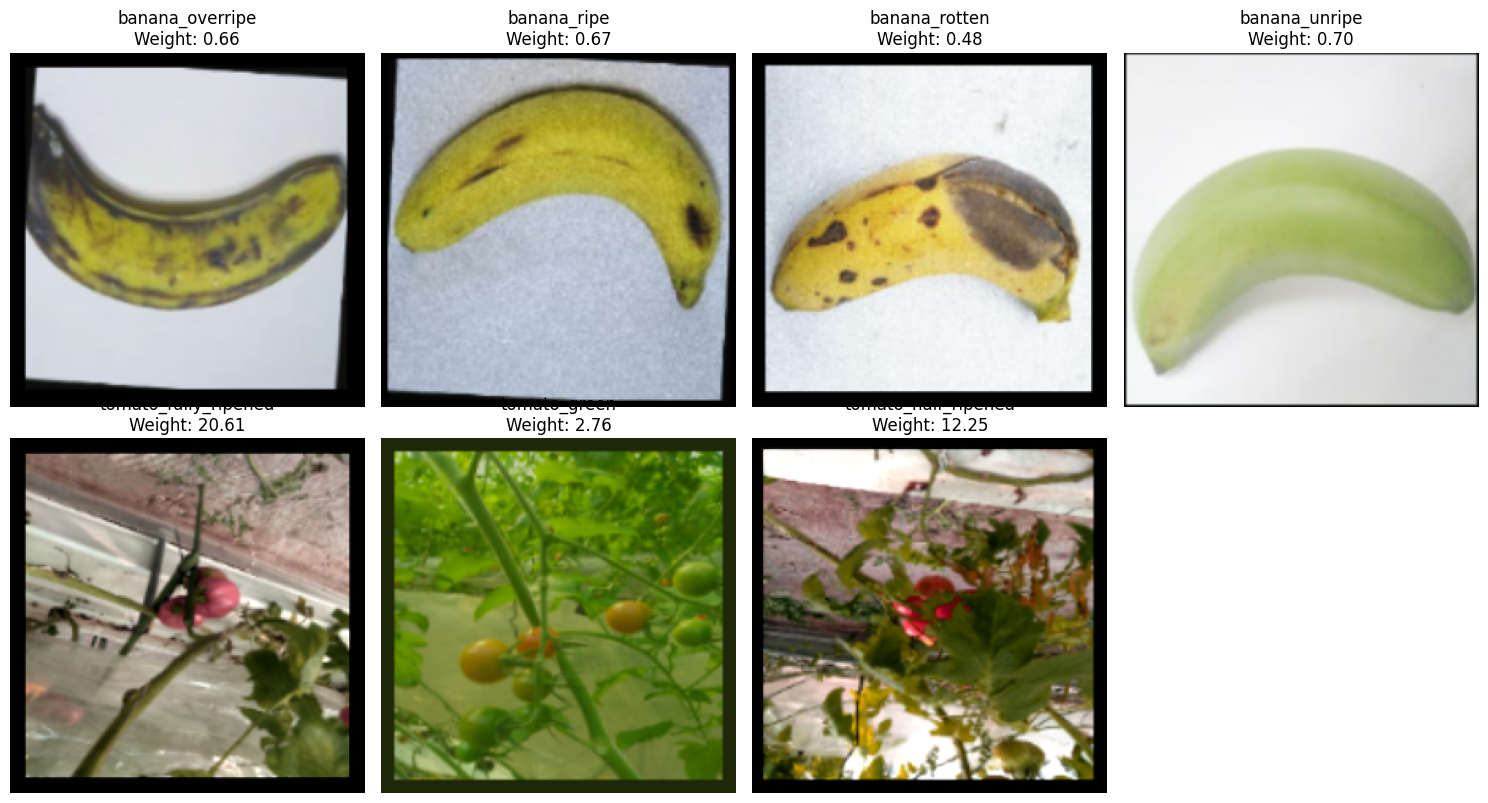

In [47]:
print("\n=== CLASS VERIFICATION ===")

class_examples = {class_name: {'image': None, 'weight': None} for class_name in class_names}

for images, labels in train_ds:
    class_indices = tf.argmax(labels, axis=1).numpy()
    for i in range(len(class_indices)):
        class_name = class_names[class_indices[i]]
        if class_examples[class_name]['image'] is None:
            class_examples[class_name]['image'] = images[i]
            class_examples[class_name]['weight'] = class_weights[class_indices[i]]
    
    if all(v['image'] is not None for v in class_examples.values()):
        break

plt.figure(figsize=(15, 8))
for idx, (class_name, example) in enumerate(class_examples.items()):
    plt.subplot(2, 4, idx+1) 
    plt.imshow(example['image'])
    plt.title(f"{class_name}\nWeight: {example['weight']:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Models

## Efficent Net B0

### Architecture

In [48]:
class_names = ['banana_overripe', 'banana_ripe', 'banana_rotten', 
               'banana_unripe', 'tomato_fully_ripened', 
               'tomato_green', 'tomato_half_ripened']

num_classes = len(class_names)


base_model = EfficientNetB0(
    include_top=False, 
    input_shape=(img_size, img_size, 3), 
    weights='imagenet'
)

base_model.trainable = False  

model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),  
    layers.Lambda(preprocess_input),  
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dropout(0.3),  
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.2),  
    layers.Dense(num_classes, activation='softmax')  
])


model.compile(
    optimizer='adam',  
    loss='categorical_crossentropy',
    metrics=['accuracy']  
)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train

In [49]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

Epoch 1/10


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 765, in start

  File "/usr/local/lib/python3.10/site-packages/anyio/_core/_eventloop.py", line 74, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2310, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 217, in run

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 435, in process_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in process_shell_message

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 361, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 457, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 606, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_10/981840314.py", line 1, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_42735]

### Predict

In [ ]:
for img_name in os.listdir(test_dataset_path):
    img_path = os.path.join(test_dataset_path, img_name)
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img) 
    img_array = preprocess_input(img_array)  
    img_array = tf.expand_dims(img_array, axis=0)  
  
    predictions = model.predict(img_array)
    

    predicted_class = tf.argmax(predictions, axis=-1).numpy()[0]
    
    submission_data.append([img_name, predicted_class])


submission_df = pd.DataFrame(submission_data, columns=['ImageID', 'Class'])

df.to_csv('kaggle/output/efficentnet_predictions.csv', index=False)
print("Efficient Net Saved Successfully \n")